<a href="https://colab.research.google.com/github/igorvojnyak/datavojnyak.github.io/blob/master/task_0_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Файл db.db - это файл базы данных sqlite. В базе собрана статистика относительно проведенных рекламных кампаний.
В базе есть две таблички **spent** и **payments**.


В табличке **spent** собраны данные о рекламных расходах и последующих событиях вплоть до инсталла в разбивке по дате, стране и операционной системе.
Описание полей из таблицы **spent**:


* date -  дата когда был потрачен бюджет (spend);
* os - операционная система устройства;
* country - страна просмотра рекламы или установки приложения(если она произошла);
* spend	- деньги потраченные на рекламу;
* impressions - количество просмотров рекламного объявления;
* clicks - количество кликов на рекламу;
* installs - количество установок приложения (размер когорты).


В табличке **payments** собраны данные о действиях когорт пользователей после инсталла (с 1 по 28 день после инсталла). Как и в таблице spent, когорта определяется тремя признаками: **date, country, os**. Данные собираются из трекинговой системы и записываются в таблицу в начале каждого дня. До тех пор, пока ts - date < 29 days.
Описание полей из таблицы **payments**:
* date - дата установки приложения
* ts - Момент сбора данных из трекинговой системы. Пример: строку со значениями [2020-06-11	2020-07-22 08:05:22.070317	ios	FR	8	3	33.77820] можно интерпретировать как "в период с 2020-06-11 по 2020-07-22 08:05:22.070317, 3 пользователя из франции с операционной системой ios, установившие приложение 11 июня, совершили 8 покупок на общую сумму 33.78".
* os - операционная система устройства;
* country - страна установки;
* purchases - количество совершенных покупок в приложении;
* unique_purchases - количество уникальных пользователей совершивших покупку.
* app_revenue - деньги полученные приложением за покупку


### Задача 1
Написать запрос который возвращает самые актуальные данные (наблюдения с максимальным ts) для каждой когорты. По актуальным наблюдениям посчитайте ARPPU (AVERAGE REVENUE PER PAYING USER) по каждой платформе отдельно. Запишите два получившихся числа в файл res1.txt через пробел (cначала показатель android потом ios).

### Задача 2
Задача рекламной кампании - окупаться в течение определенного периода времени. Рассмотрим окупаемость кампании через 28 дней после инсталла. Сравним, как изменилась окупаемость по платформам в июле по сравнению с июнем. Для этого найдем информацию о платежах на где (ts - date) равняется 28 дням. Данные о расходах можно взять из таблицы spent.
Посчитайте помесячно roas_28d = revenue_28d / spend для каждой платформы (на той части данных на которой это возможно сделать). В файл ответа res2.txt запишите коэффициент роста (темп роста) roas_28d android и ios через пробел.


### Задача 2.1 (со звездочкой)
Дайте прогноз roas_28d на июль месяц. Точность не так важна как выбранная вами методология. Не тратьте слишком много времени на это задание)


### Задача 3
Представьте, что сегодня 2020-08-16 и вам нужно дать рекоммендации отделу по закупке трафика.
Проанализировав данные, скажите:
* какая динамика наблюдается в целом? (рекомендуем построить воронку конверсий от impression до конверсии в покупку)
* какие сегменты имеют хорошие показатели и могут масштабироваться;
* какие сегменты находятся в серой зоне и **что можно сделать** для улучшения их перфоманса;
* какие сегменты скорее всего безнадежны и на них не стоит тратить бюджеты.

Исходите из предположения о том, что норма roas_28d = 1.2


**Решение тестового задания должно содержать Jupyter Notebook c решением, текстовые файлы res1.txt, res2.txt**

In [ ]:
import sqlite3
import pandas as pd

In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [ ]:
conn = sqlite3.connect('/content/drive/My Drive/db.db')

In [ ]:
spent = pd.read_sql_query("SELECT * from spent;", conn)
spent

,date,os,country,spend,impressions,clicks,installs
0,2020-06-01,android,AD,0.02,32,2,2
1,2020-06-01,android,AE,2.73,1167,19,8
2,2020-06-01,android,AF,0.07,110,4,0
3,2020-06-01,android,AG,0.04,26,0,0
4,2020-06-01,android,AL,0.13,70,1,1
...,...,...,...,...,...,...,...
11817,2020-08-15,ios,VN,2.02,495,14,1
11818,2020-08-15,ios,XK,0.14,44,3,0
11819,2020-08-15,ios,ZA,0.44,83,1,0
11820,2020-08-15,ios,ZM,0.03,6,0,0


In [ ]:
payments = pd.read_sql_query("SELECT * from payments;", conn)
payments

,date,ts,os,country,purchases,unique_purchases,app_revenue
0,2020-08-04,2020-08-14 04:04:06.608152,ios,US,3,2,9.97000
1,2020-07-28,2020-07-29 04:03:56.516653,ios,NL,0,0,0.00000
2,2020-06-14,2020-07-09 04:02:08.915834,ios,SA,8,2,33.80310
3,2020-06-10,2020-06-13 04:05:36.297502,android,IQ,0,0,0.00000
4,2020-06-14,2020-06-28 04:04:59.576784,android,LB,0,0,0.00000
...,...,...,...,...,...,...,...
122936,2020-07-15,2020-07-30 04:03:56.181009,ios,BG,0,0,0.00000
122937,2020-07-20,2020-08-11 04:04:04.930876,android,SA,0,0,0.00000
122938,2020-07-09,2020-07-31 04:03:58.571797,android,KZ,0,0,0.00000
122939,2020-07-09,2020-08-01 04:04:08.334394,android,BR,2,1,8.61275


Задание 1

In [181]:
df_android = pd.read_sql_query("select sum(app_revenue)/count(distinct os) as result_android from (select *, max(ts) from payments  group by date, country, os order by max(ts)) where os='android';", conn)
df_android

,result_android
0,29463.589265


In [182]:
df_ios = pd.read_sql_query("select sum(app_revenue)/count(distinct os) as results_ios from (select *, max(ts) from payments  group by date, country, os order by max(ts)) where os='ios';", conn)
df_ios

,results_ios
0,37882.479279


In [ ]:
data = pd.concat([df_ios,df_android])
data.to_csv('res1.txt', header=False, index=False,sep='\t')

задание 2

In [197]:
roas_28d_android_july= pd.read_sql_query("select (spend/app_revenue) roas_28d,platform ,month, spend, date_28, days,app_revenue from (select strftime('%m', date) as month, payments.date as date_28,os as platform,payments.app_revenue, julianday(ts)-julianday(date) as days from  payments where days>=28 and platform='android'),spent where julianday(date_28)= julianday(spent.date) and month='07' ;", conn)
roas_28d_android_july

,roas_28d,platform,month,spend,date_28,days,app_revenue
0,0.217732,android,07,65.67,2020-07-08,28.169491,301.61000
1,0.216472,android,07,65.29,2020-07-08,28.169491,301.61000
2,NaN,android,07,0.01,2020-07-09,28.169515,0.00000
3,NaN,android,07,0.01,2020-07-09,28.169515,0.00000
4,NaN,android,07,0.01,2020-07-09,28.169515,0.00000
...,...,...,...,...,...,...,...
62568,0.229779,android,07,0.52,2020-07-18,28.168305,2.26304
62569,0.094280,android,07,0.52,2020-07-18,28.168305,5.51546
62570,0.031646,android,07,0.52,2020-07-18,28.168305,16.43200
62571,0.007855,android,07,0.52,2020-07-18,28.168305,66.20070


In [ ]:
roas_28d_android_july= pd.read_sql_query("select (spend/app_revenue) roas_28d,platform ,month, spend, date_28, days,app_revenue from (select strftime('%m', date) as month, payments.date as date_28,os as platform,payments.app_revenue, julianday(ts)-julianday(date) as days from  payments where days>=28 and platform='android'),spent where julianday(date_28)= julianday(spent.date) and month='07' ;", conn)
#roas_28d_android_july
roas_28d_android_june= pd.read_sql_query("select (spend/app_revenue) roas_28d,platform ,month, spend, date_28, days,app_revenue from (select strftime('%m', date) as month, payments.date as date_28,os as platform,payments.app_revenue, julianday(ts)-julianday(date) as days from  payments where days>=28 and platform='android'),spent where julianday(date_28)= julianday(spent.date) and month='06' ;", conn)
roas_28d_android_june

,roas_28d,platform,month,spend,date_28,days,app_revenue
0,NaN,android,06,0.02,2020-06-01,28.170311,0.0000
1,NaN,android,06,0.02,2020-06-01,28.170311,0.0000
2,NaN,android,06,0.02,2020-06-01,28.170311,0.0000
3,NaN,android,06,0.02,2020-06-01,28.170311,0.0000
4,NaN,android,06,0.02,2020-06-01,28.170311,0.0000
...,...,...,...,...,...,...,...
496103,NaN,android,06,0.01,2020-06-25,28.169418,0.0000
496104,NaN,android,06,0.01,2020-06-25,28.169418,0.0000
496105,NaN,android,06,0.01,2020-06-25,28.169418,0.0000
496106,0.000780,android,06,0.01,2020-06-25,28.169418,12.8191


2.5887100654410076


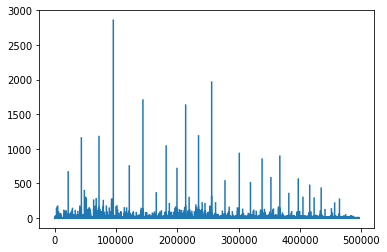

In [ ]:
print(roas_28d_android_june['roas_28d'].mean())
roas_28d_android_june['roas_28d'].plot()
plt.show()

1.9538882284847792


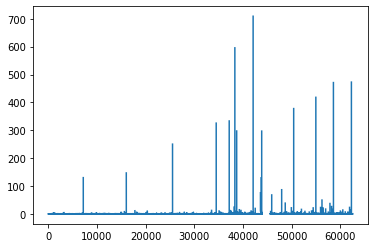

In [ ]:
print(roas_28d_android_july['roas_28d'].mean())
roas_28d_android_july['roas_28d'].plot()
plt.show()

In [ ]:
roas_28d_ios_july= pd.read_sql_query("select (spend/app_revenue) roas_28d , spend,platform,month, date_28, days,app_revenue from (select strftime('%m', date) as month, payments.date as date_28,os as platform,payments.app_revenue, julianday(ts)-julianday(date) as days from  payments where days>=28 and platform='ios'),spent where julianday(date_28)= julianday(spent.date) and month='07' ;", conn)
#roas_28d_ios_july
roas_28d_ios_june= pd.read_sql_query("select (spend/app_revenue) roas_28d , spend,platform, month, date_28, days,app_revenue from (select strftime('%m', date) as month, payments.date as date_28,os as platform,payments.app_revenue, julianday(ts)-julianday(date) as days from  payments where days>=28 and platform='ios'),spent where julianday(date_28)= julianday(spent.date) and month='06'  ;", conn)
#roas_28d_ios_june

2.259822535390841


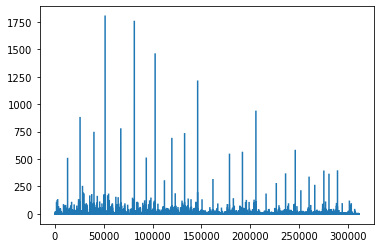

In [ ]:
print(roas_28d_ios_june['roas_28d'].mean())
roas_28d_ios_june['roas_28d'].plot()
plt.show()

1.2867043443530515


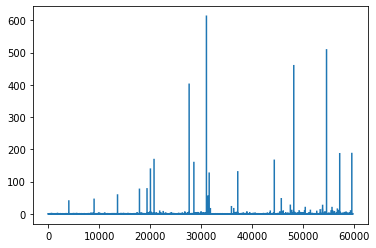

In [ ]:
print(roas_28d_ios_july['roas_28d'].mean())
roas_28d_ios_july['roas_28d'].plot()
plt.show()

In [201]:
f = open("res2.txt", "a")
f.write(str(roas_28d_android_july['roas_28d'].mean()))
f.write(" ")
f.write(str(roas_28d_ios_july['roas_28d'].mean()))
f.close()

In [196]:
#res2= pd.read_sql_query("select date,platej,os, app_revenue from (select date,os,payments.app_revenue, julianday(ts)-julianday(date) as platej from  payments where platej>=28);", conn)


задание 2.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
roas_28d_june= pd.read_sql_query("select (spend/app_revenue) roas_28d ,month, spend, date_28, days,app_revenue from (select strftime('%m', date) as month, payments.date as date_28,os as platform,payments.app_revenue, julianday(ts)-julianday(date) as days from  payments where days>=28 ),spent where julianday(date_28)= julianday(spent.date) and month='06' ;", conn)
roas_28d_july= pd.read_sql_query("select (spend/app_revenue) roas_28d ,month, spend, date_28, days,app_revenue from (select strftime('%m', date) as month, payments.date as date_28,os as platform,payments.app_revenue, julianday(ts)-julianday(date) as days from  payments where days>=28 ),spent where julianday(date_28)= julianday(spent.date) and month='07' ;", conn)

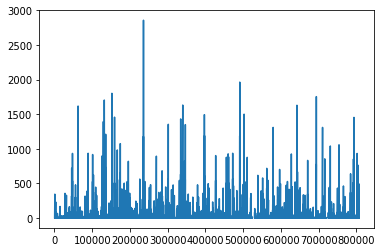

In [ ]:
roas_28d_june['roas_28d'].plot()
plt.show()

In [ ]:
roas_28d_june.shape

(807833, 7)

In [ ]:
roas_28d_june = roas_28d_june.fillna(0)
roas_28d_july = roas_28d_july.fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = roas_28d_july[['spend','app_revenue']], roas_28d_july[['roas_28d']]
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.3, random_state=0)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = regressor.predict(X_test)
print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))

Linear Regression R squared": 0.0541


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 6.4747


Задание 3

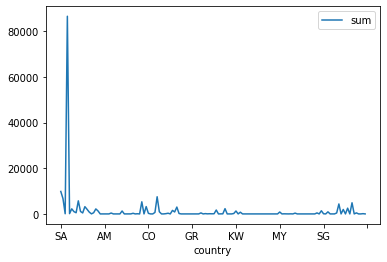

In [ ]:
# df = pd.read_sql_query("select country, sum(purchases) as sum  from payments where os='ios'  group by country order by purchases desc;", conn)
# df.plot(kind='line',x='country',y='sum')

In [165]:
# df = pd.read_sql_query("select sum(purchases) as sum  from payments where os='android'  ;", conn)
# df

,sum
0,182766


In [166]:
# df = pd.read_sql_query("select sum(installs) as sum from spent where os='android';", conn)
# df

,sum
0,66178


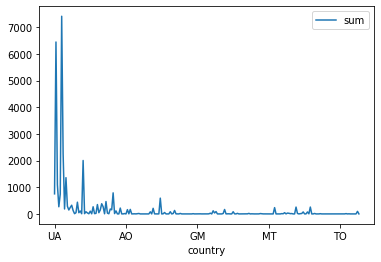

In [ ]:
# df = pd.read_sql_query("select country, sum(installs) as sum from spent where os='ios'  group by country order by installs desc ;", conn)
# df.plot(kind='line',x='country',y='sum')

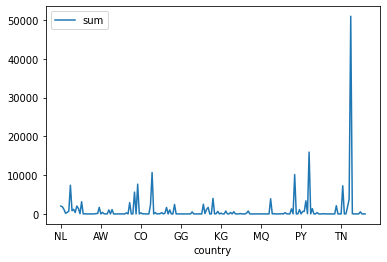

In [ ]:
# df = pd.read_sql_query("select country, sum(purchases) as sum  from payments where os='android'  group by country order by purchases desc ;", conn)
# df.plot(kind='line',x='country',y='sum')

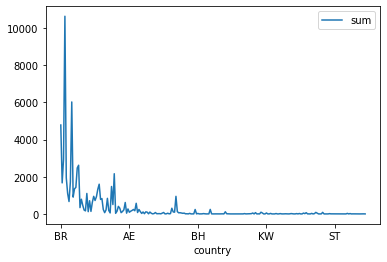

In [ ]:
# df = pd.read_sql_query("select country, sum(installs) as sum from spent where os='android'  group by country order by installs desc ;", conn)
# df.plot(kind='line',x='country',y='sum')

Задание 3


В целом наблюдается положительная динамика Исходите из предположения о том, что норма roas_28d = 1.2, показатели показывают, в среднем roas_28d показывает значения 1.9538 для android и 1.28670 для ios,  воронку конверсий от impression до конверсии в покупку примерно 2% 
Сегменты  аудитории android имеют хорошие показатели,   monthly average purchases хороший учитывая затраты на пользователя, странах NL,CO, TN, PY, BR AE BH, процент пользователей делают покупки около 36%. В серой зоне страны где мало используют ios, это MY, SG, GR.. показатели purshase низкие и количество install также низкие, процент пользователей делают покупки около 17%, думаю для увеличиния обьема трафика, можно увеличить ставки, расширять закупки на новый страны, можно увеличит количество инсталов.
Пологаю сегменты которые имеют количество inastalls меньше 1000, не будут иметь потребность в продукте, в основном это страны мало пользующие ios устройствами это MT,TO,GM.. общие количества installs меньше<1000

